# **Построение SVC**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import connected_components
from cvxopt import matrix, solvers
import pandas as pd

class SV_claster:
    def __init__(self, q, p, num_segments_check=10, sv_tol=1e-3):
        self.q = q  # Параметр для Гауссова ядра
        self.p = p    # Параметр p (Верхняя граница доли связных опорных векторов)
        self.num_segments_check = num_segments_check # Сколько точек проверять на отрезке для связности
        self.sv_tol = sv_tol # Порог
        self.C_param = None

        # результаты после обучения
        self.X_train_ = None
        self.betas_ = None          # Найденные коэффициенты beta
        self.support_indices_ = None # Индексы опорных векторов
        self.support_vectors_ = None # Сами опорные векторы
        self.n_sv_ = 0
        self.n_bsv_ = 0             # Ограниченные BSV, где beta_i близко к C

        self.R_squared_ = None      # Квадрат "радиуса" найденной сферы
        self.Ca_ = None             # Константа: sum_ij beta_i beta_j K(xi, xj)

        self.labels_ = None         # Метки кластеров для каждой точки
        self.n_clusters_ = 0

    # Гауссово ядро: K(p1, p2) = exp(-gamma * ||p1-p2||^2)
    def _kernel(self, p1, p2):
        return np.exp(-self.q * np.sum((np.asarray(p1) - np.asarray(p2))**2))

    # Ядро между одной точкой (point_vec) и всеми точками в матрице (X_matrix)
    def _kernel_point_to_matrix(self, point_vec, X_matrix):
        p_vec = np.asarray(point_vec).reshape(1, -1) # Гарантируем, что это вектор-строка
        x_mat = np.asarray(X_matrix)
        return np.exp(-self.q * np.sum((p_vec - x_mat)**2, axis=1))

    def fit(self, X):
        self.X_train_ = np.asarray(X)
        n_samples = self.X_train_.shape[0]
        self.C_param = round(1/(n_samples * self.p), 2)

        # 1. Считаем матрицу K_ij = kernel(X_i, X_j)
        K_gram = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(i, n_samples):
                val = self._kernel(self.X_train_[i], self.X_train_[j])
                K_gram[i, j] = val
                K_gram[j, i] = val

        # 2. Решаем задачу QP
        # Минимизируем: (1/2) * beta^T * P_qp * beta + q_qp^T * beta
        # P_qp = 2 * K_gram
        # q_qp = вектор из -1
        epsilon_reg = 1e-9
        P_qp_cvx = matrix(2 * K_gram + epsilon_reg * np.eye(n_samples))
        q_qp_cvx = matrix(-np.ones(n_samples))

        # Ограничения:
        # G_qp * beta <= h_qp  (для 0 <= beta_i <= C)
        G_np = np.vstack([-np.eye(n_samples), np.eye(n_samples)]) # -beta <= 0; beta <= C
        h_np = np.hstack([np.zeros(n_samples), self.C_param * np.ones(n_samples)])
        G_qp_cvx = matrix(G_np)
        h_qp_cvx = matrix(h_np)

        # A_qp * beta = b_qp (для sum(beta_i) = 1)
        A_qp_cvx = matrix(np.ones((1, n_samples)))
        b_qp_cvx = matrix(1.0)

        solvers.options['show_progress'] = False

        solution = solvers.qp(P_qp_cvx, q_qp_cvx, G_qp_cvx, h_qp_cvx, A_qp_cvx, b_qp_cvx)

        if solution['status'] != 'optimal':
            raise RuntimeError(f"ошибка {solution['status']}")

        self.betas_ = np.array(solution['x']).flatten()
        self.betas_[self.betas_ < 0] = 0

        # 3. Находим Опорные Векторы (SVs)
        self.support_indices_ = np.where(self.betas_ > self.sv_tol)[0]

        self.support_vectors_ = self.X_train_[self.support_indices_]
        self.n_sv_ = len(self.support_indices_)

        # Ограниченные SV (BSV) - те, у которых beta_i близко к C
        self.n_bsv_ = np.sum(self.betas_[self.support_indices_] >= self.C_param - self.sv_tol)

        # 4. Считаем параметры сферы: Ca и R^2
        # Ca = beta^T * K_gram * beta
        self.Ca_ = self.betas_.T @ K_gram @ self.betas_

        # расчет R^2:
        # R^2 = min( D(x_sv)^2 ) для всех опорных векторов x_sv.
        # D(x)^2 = 1 - 2 * sum(beta_i * K(x, X_i)) + Ca
        min_Dx_sq_for_sv = float('inf')
        for sv_idx in self.support_indices_:
            # K(X_sv[idx], X_train_i) для всех i
            kernels_sv_X = self._kernel_point_to_matrix(self.X_train_[sv_idx], self.X_train_)
            sum_beta_K_sv = np.sum(self.betas_ * kernels_sv_X)
            Dx_sq = 1.0 - 2 * sum_beta_K_sv + self.Ca_
            if Dx_sq < min_Dx_sq_for_sv:
                min_Dx_sq_for_sv = Dx_sq
        self.R_squared_ = min_Dx_sq_for_sv

        # 5. Делим на кластеры на основе графа связности
        self._build_clusters_graph(self.X_train_)

    # Вспомогательная функция: считает D(x)^2 = ||Phi(x) - a||^2 для точки x
    def _get_Dx_squared(self, x_point):
        # Использует уже вычисленные self.betas_, self.X_train_, self.Ca_
        kernels_x_Xtrain = self._kernel_point_to_matrix(x_point, self.X_train_)
        sum_beta_K_x_Xtrain = np.sum(self.betas_ * kernels_x_Xtrain)
        # K(x,x)=1 для Гауссова ядра
        return 1.0 - 2 * sum_beta_K_x_Xtrain + self.Ca_

    # Проверка, находится ли точка внутри сферы (D(x)^2 <= R^2)
    def _is_in_sphere(self, x_point, radius_tol=1e-9): # Небольшой допуск
        if self.R_squared_ is None: return False # Если R^2 не определен
        return self._get_Dx_squared(x_point) <= self.R_squared_ + radius_tol

    # Строим граф смежности и находим кластеры (связные компоненты)
    def _build_clusters_graph(self, X):
        n_samples = X.shape[0]
        adj_matrix = np.zeros((n_samples, n_samples), dtype=int)

        # Сначала проверим, какие точки вообще внутри основной области сферы
        point_in_sphere_flags = np.array([self._is_in_sphere(X[i]) for i in range(n_samples)])

        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                segment_is_good = True
                for k_seg in range(1, self.num_segments_check + 1):
                    t = k_seg / (self.num_segments_check + 1.0)
                    point_on_segment = (1 - t) * X[i] + t * X[j]
                    if not self._is_in_sphere(point_on_segment):
                        segment_is_good = False
                        break # Отрезок плохой, дальше не проверяем

                if segment_is_good: # Если весь отрезок хороший
                    adj_matrix[i, j] = 1
                    adj_matrix[j, i] = 1 # Граф неориентированный

        self.n_clusters_, self.labels_ = connected_components(
            csgraph=adj_matrix, directed=False, return_labels=True
        )

    # Функция для рисования кластеров
    def plot_clusters(self):
        X_plot = self.X_train_
        fig, ax = plt.subplots(figsize=(10, 7.5))

        # Подбираем карту цветов
        num_unique_labels = len(np.unique(self.labels_))
        cmap_name = 'viridis' # По умолчанию
        if num_unique_labels > 0:
            if num_unique_labels == 1: cmap_name = 'winter'
            elif num_unique_labels <= 10: cmap_name = 'tab10'
            else: cmap_name = 'nipy_spectral' # Если много кластеров

        colors_map = plt.cm.get_cmap(cmap_name, max(1, num_unique_labels))

        # Рисуем точки данных
        ax.scatter(X_plot[:, 0], X_plot[:, 1], c=self.labels_, cmap=colors_map,
                   s=40, edgecolors='black', alpha=0.85, zorder=2)

        # Рисуем Опорные Векторы (SVs)
        if self.support_vectors_ is not None and len(self.support_vectors_) > 0:
            ax.scatter(self.support_vectors_[:, 0], self.support_vectors_[:, 1],
                       s=160, facecolors='none', edgecolors='red', linewidths=1.8,
                       label=f'SVs: {self.n_sv_}', zorder=4, marker='o')

            # Рисуем Ограниченные SV (BSVs) - те SV, у которых beta почти равно C
            if self.n_bsv_ > 0:
                # Выбираем BSV из уже найденных SV
                bsv_mask = self.betas_[self.support_indices_] >= self.C_param - self.sv_tol
                actual_bsv_points = self.support_vectors_[bsv_mask]
                if len(actual_bsv_points) > 0:
                    ax.scatter(actual_bsv_points[:, 0], actual_bsv_points[:, 1],
                               s=220, facecolors='none', edgecolors='blue', linewidths=1.8, linestyle=':',
                               label=f' BSVs: {self.n_bsv_}', zorder=5, marker='X')

        # Рисуем контур сферы: D(x)^2 - R^2 = 0
        if self.R_squared_ is not None:
            # Определяем границы сетки для контура
            x_min, x_max = X_plot[:, 0].min() - 0.5, X_plot[:, 0].max() + 0.5
            y_min, y_max = X_plot[:, 1].min() - 0.5, X_plot[:, 1].max() + 0.5
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 70),
                                 np.linspace(y_min, y_max, 70))

            grid_points = np.c_[xx.ravel(), yy.ravel()]
            # Считаем D(p)^2 для каждой точки сетки p (простой цикл, не самый быстрый)
            Z_values_Dx_sq = np.array([self._get_Dx_squared(p) for p in grid_points])

            Z_contour = (Z_values_Dx_sq - self.R_squared_).reshape(xx.shape)
            ax.contour(xx, yy, Z_contour, levels=[0], linewidths=2, colors='black', zorder=3)


        # Заголовок и метки осей
        title_str = (f"SVC Кластеризация \n"
                     f"\q={self.q}, p={self.p}\n"
                     f"Кластеры: {self.n_clusters_}, SVs: {self.n_sv_}, BSVs: {self.n_bsv_}")
        ax.set_title(title_str, fontsize=13)
        ax.set_xlabel("Признак X1", fontsize=11)
        ax.set_ylabel("Признак X2", fontsize=11)


        if self.n_sv_ > 0 :
            ax.legend(loc='best', fontsize=9)

        ax.grid(True, linestyle=':', alpha=0.5)
        fig.tight_layout()
        plt.show()

# **Работа с данными - гауссовские облака**

**генерируем данные**

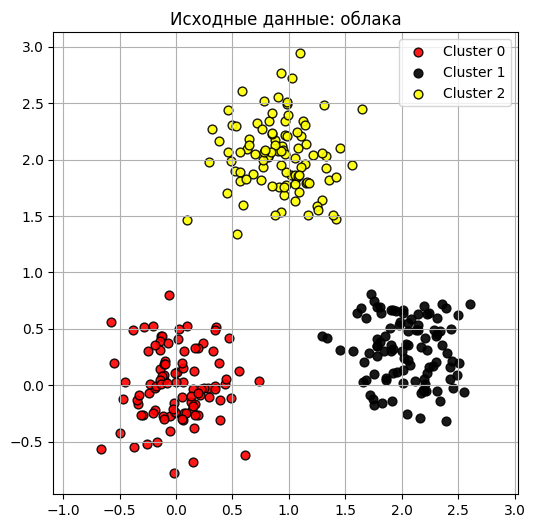

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(52)

centers = np.array([
    [0.0, 0.0],   # кластер 0 (красный)
    [2.0, 0.3],   # кластер 1 (чёрный)
    [0.9, 2.0],   # кластер 2 (жёлтый)
])

n_per_cluster = 100
scale = 0.3

# генерируем данные
X = np.vstack([
    rng.normal(loc=ctr, scale=scale, size=(n_per_cluster, 2))
    for ctr in centers
])

# формируем метки той же длины
y = np.hstack([
    np.full(n_per_cluster, k, dtype=int)   # k = 0,1,2
    for k in range(len(centers))
])

# визуализация
colors = ['red', 'black', 'yellow']
plt.figure(figsize=(6, 6))
for lab, col in zip(range(len(centers)), colors):
    plt.scatter(X[y == lab, 0], X[y == lab, 1],
                c=col, s=40, edgecolor='k', alpha=0.9,
                label=f'Cluster {lab}')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.title("Исходные данные: облака")
plt.show()

n_sample = X.shape[0]

**подбор значений гиперпараметров**

P с которого начинаем

In [ ]:
p_start = round(1/n_sample,3)
p_start

0.003

In [ ]:
d2 = np.sum((X[:,None,:] - X[None,:,:])**2, axis=2)
q_start = round(1.0 / d2.max(),3)
q_start

np.float64(0.065)

<ipython-input-2-a454858fd87c>:162: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_map = plt.cm.get_cmap(cmap_name, max(1, num_unique_labels))


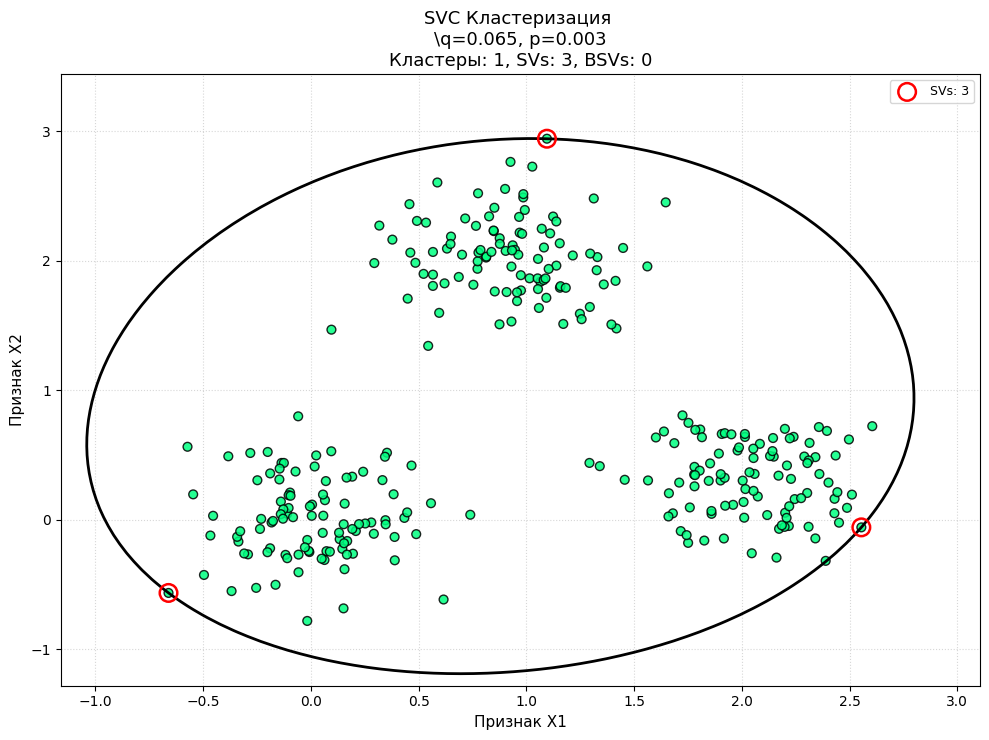

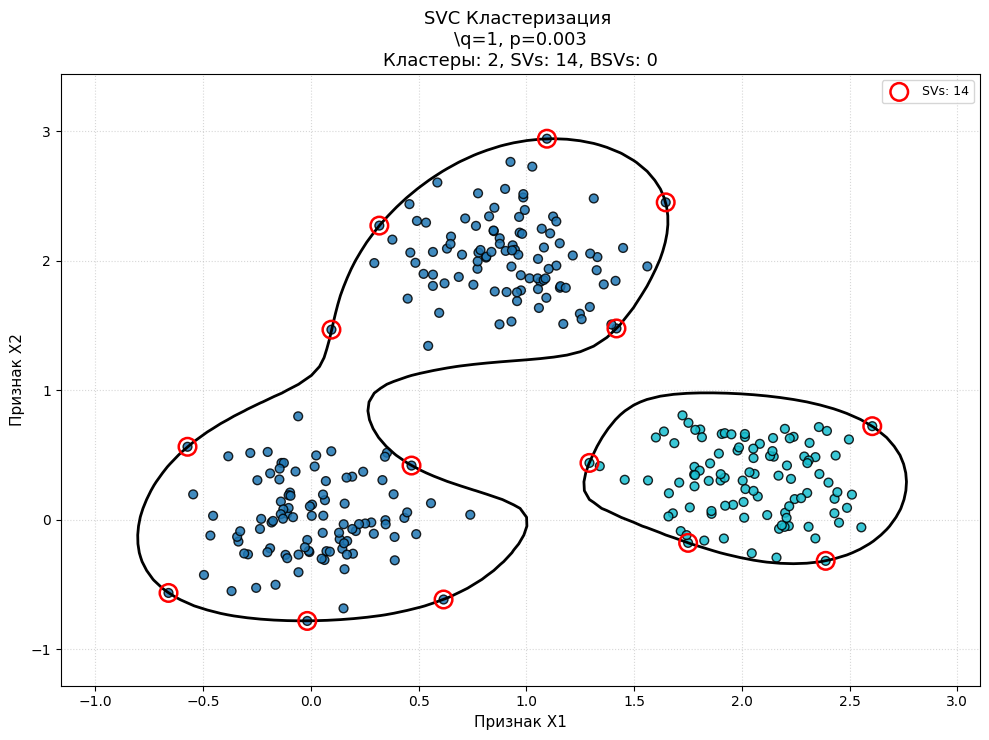

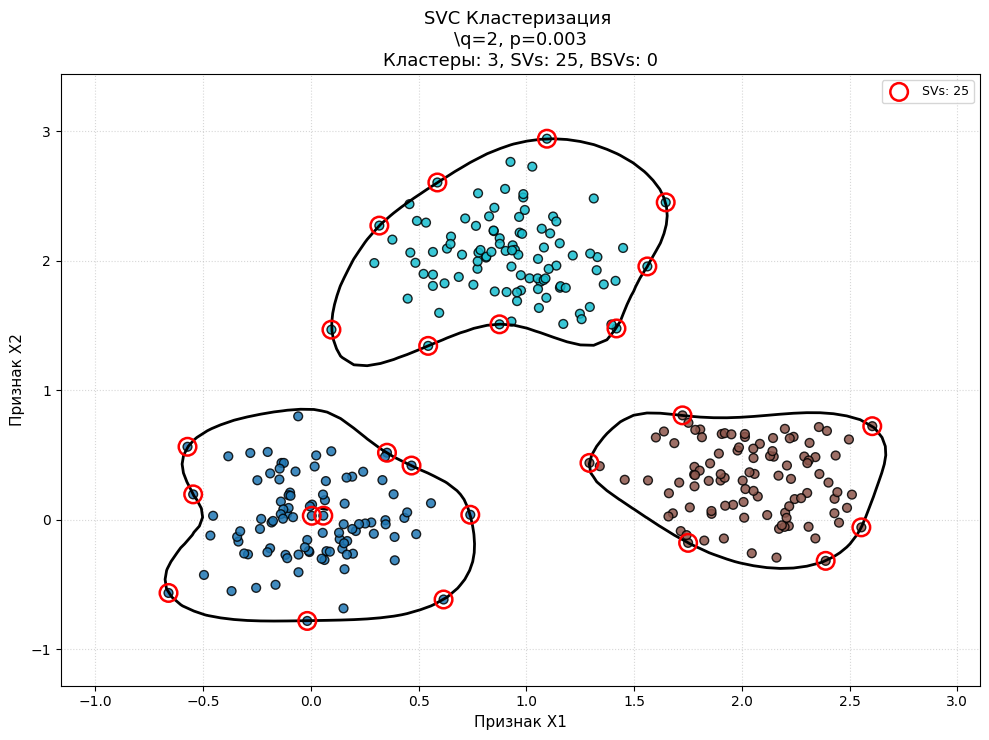

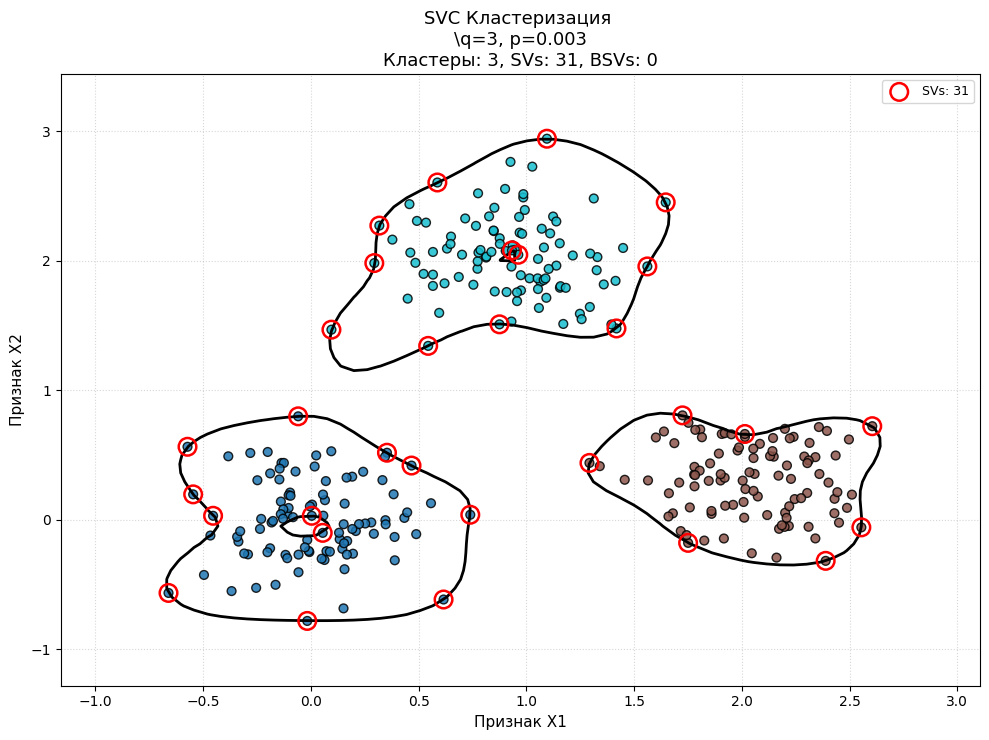

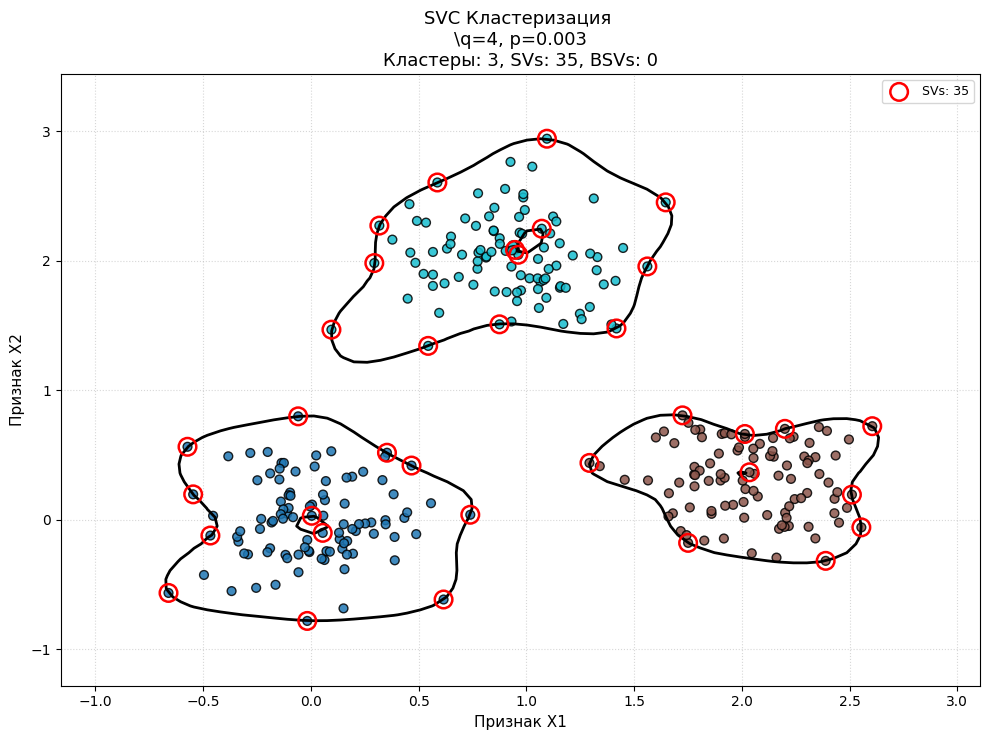

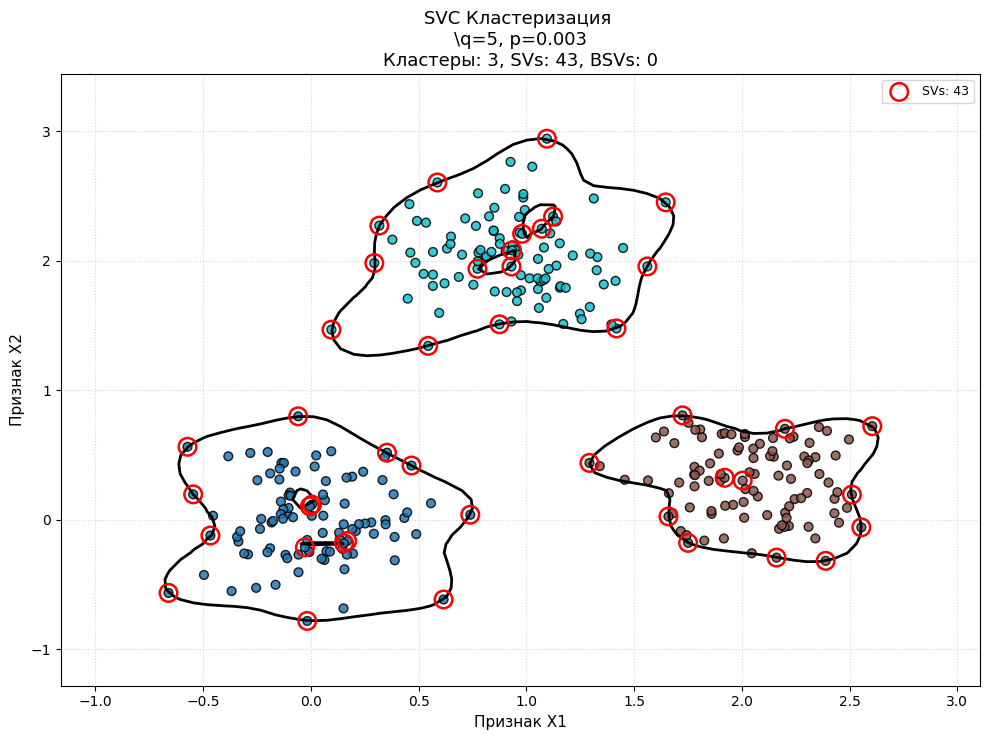

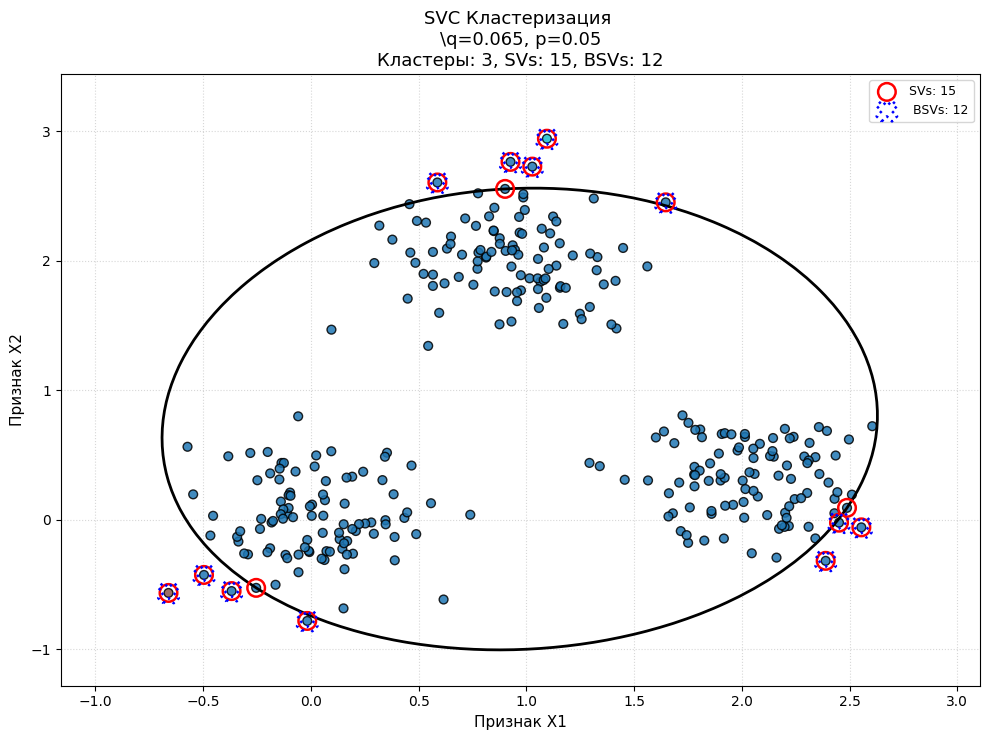

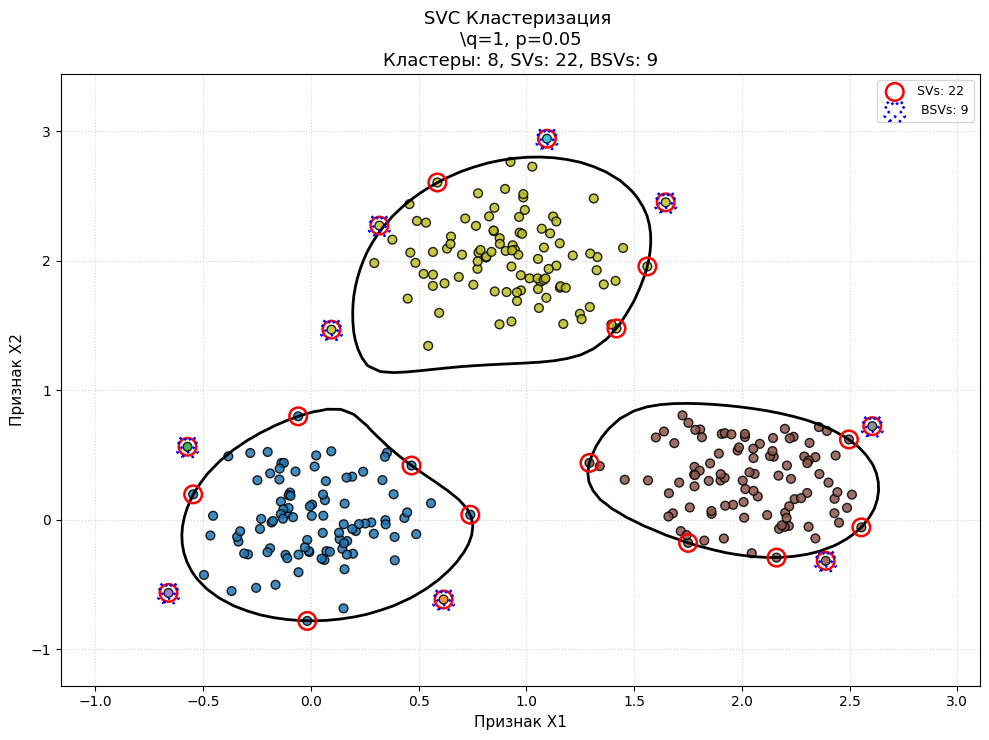

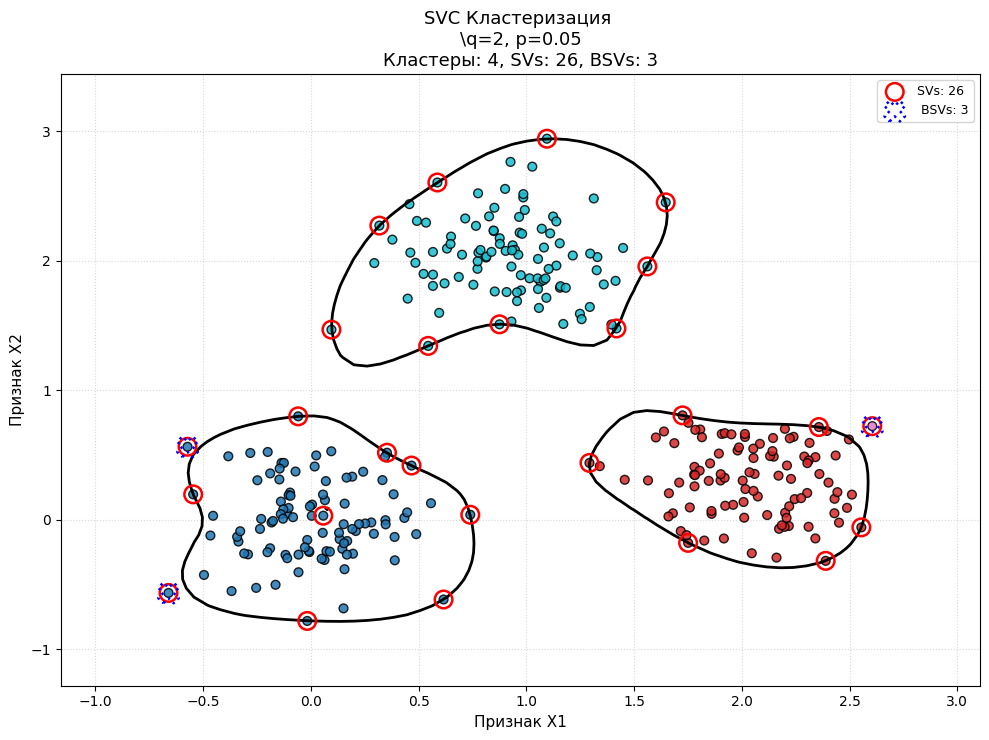

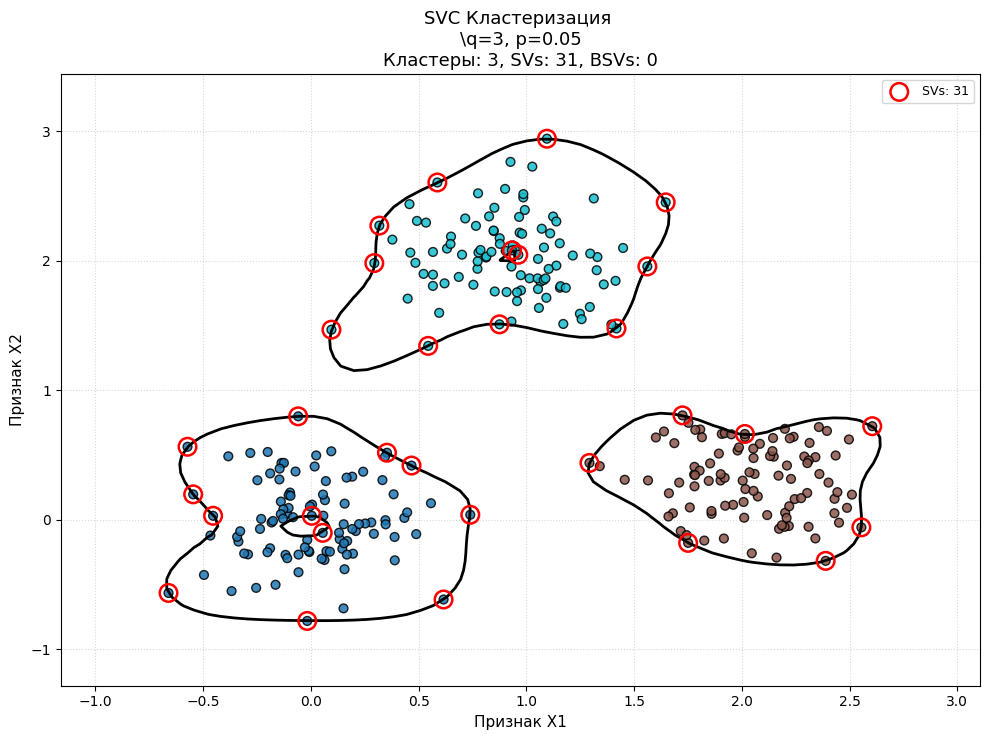

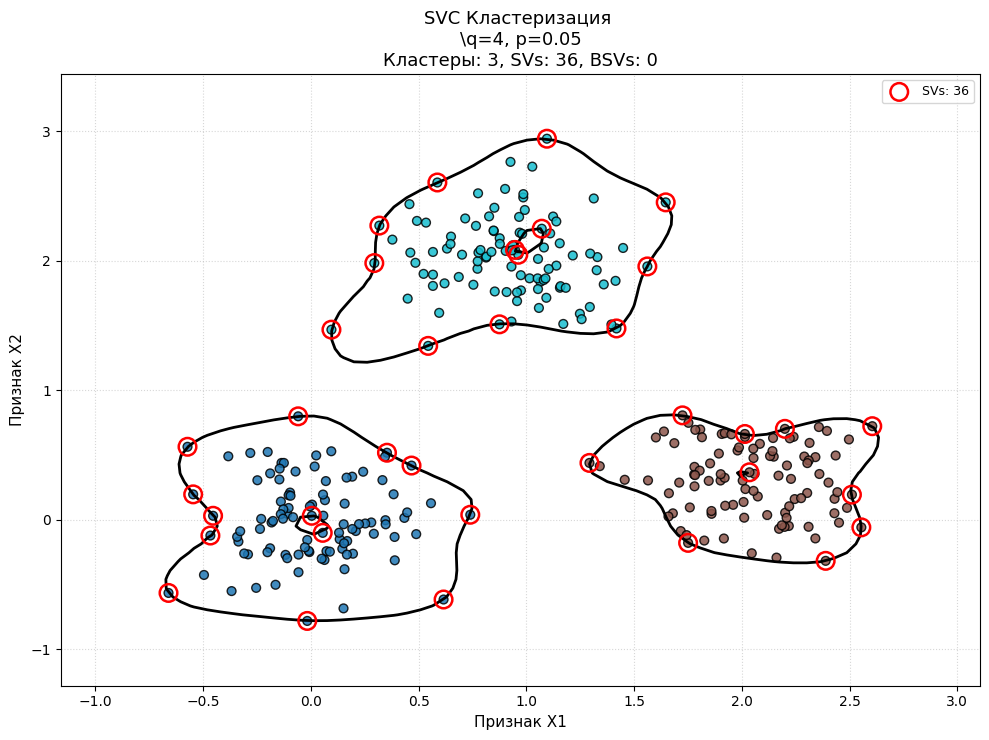

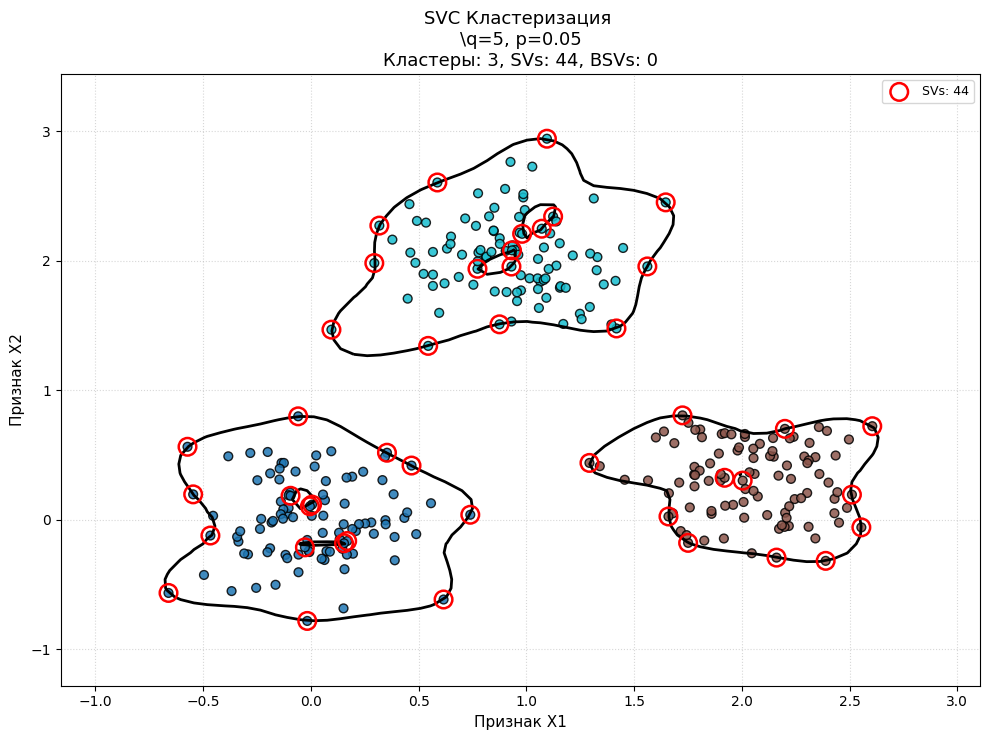

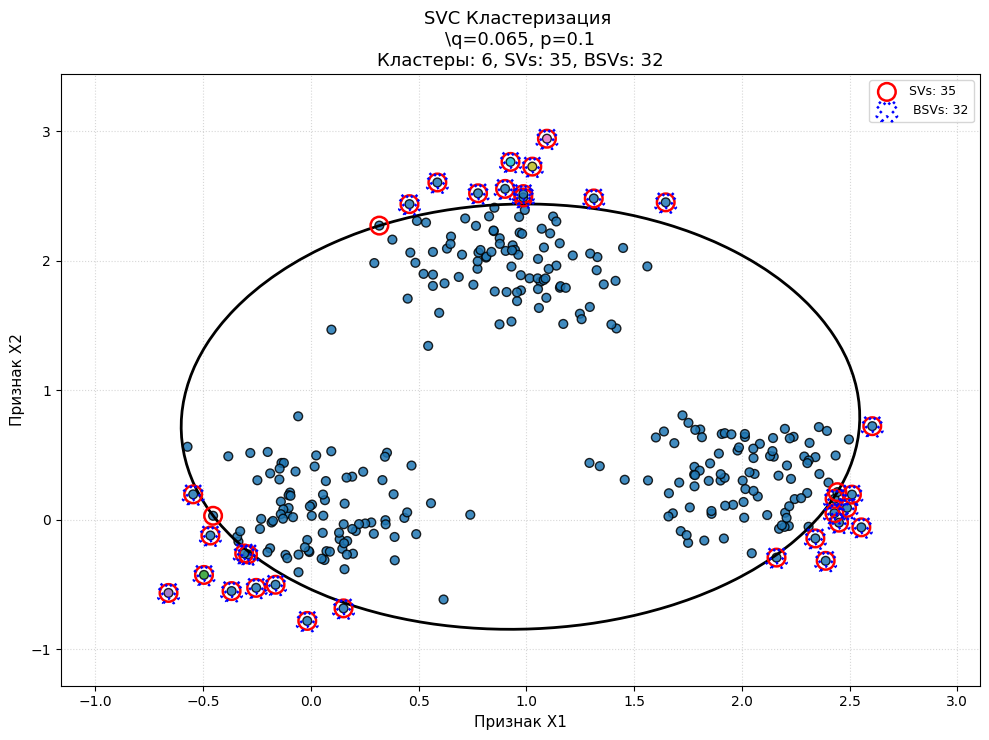

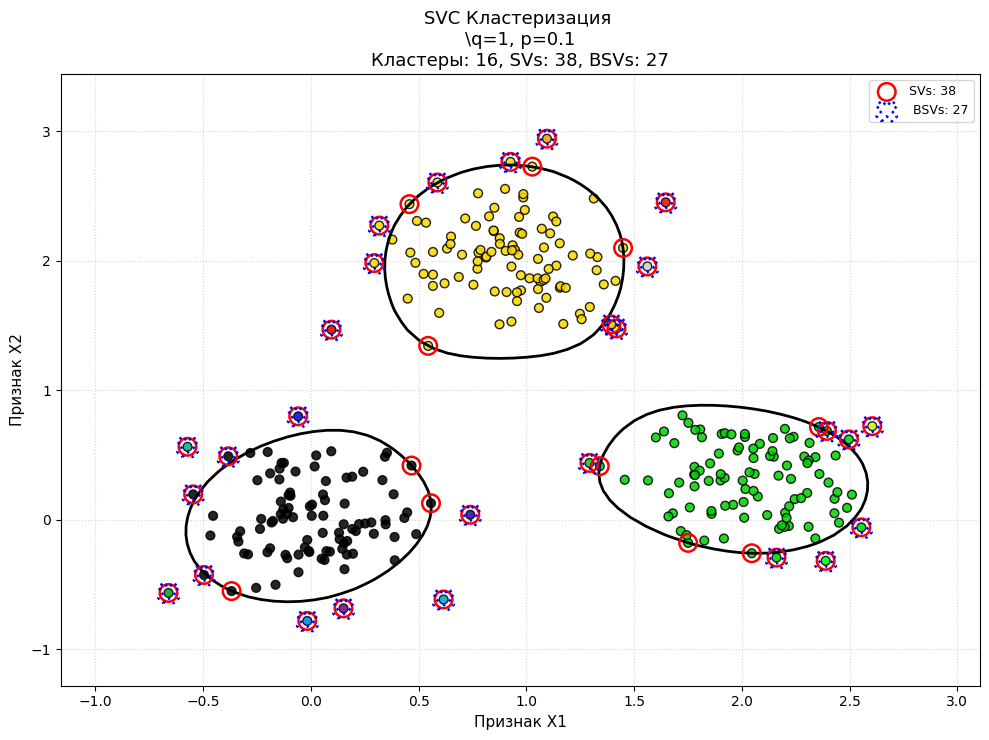

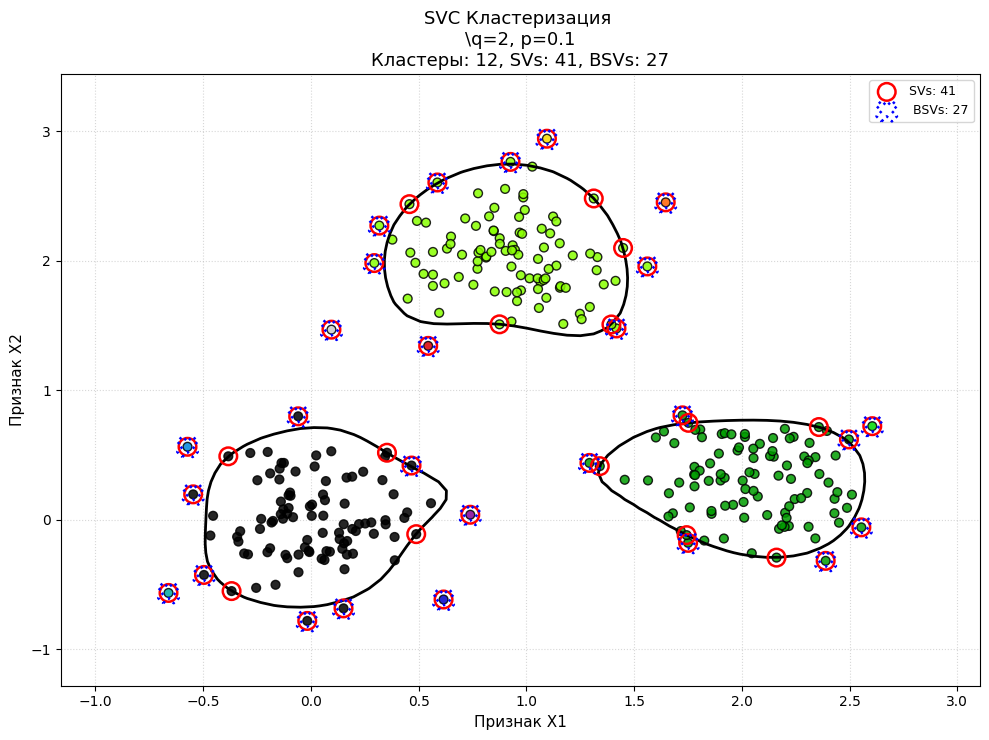

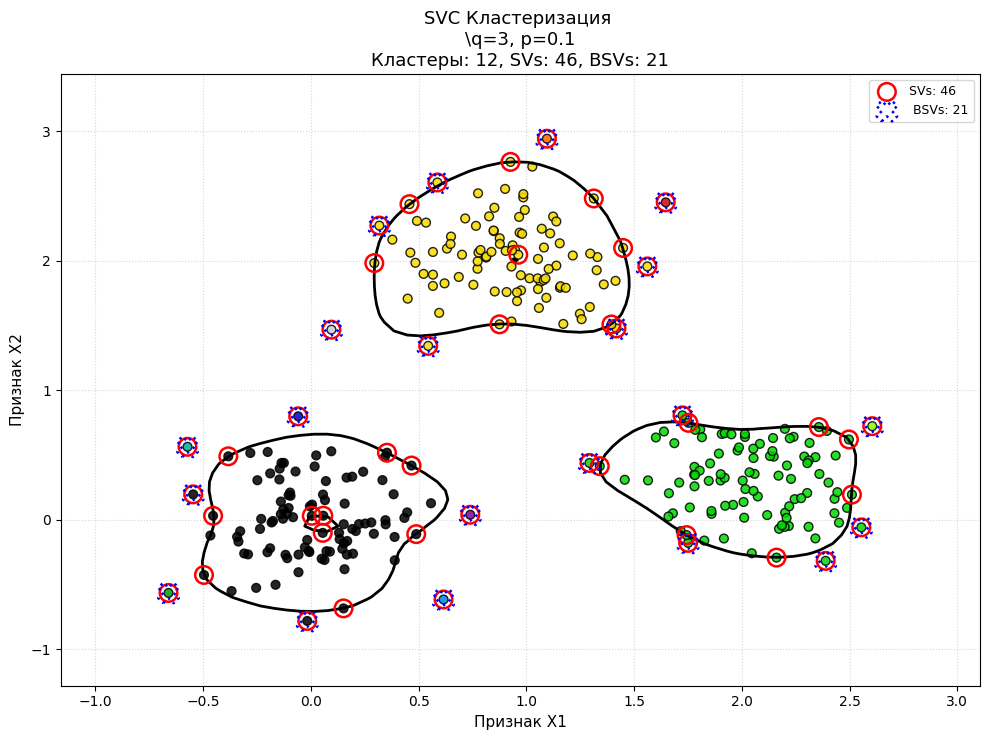

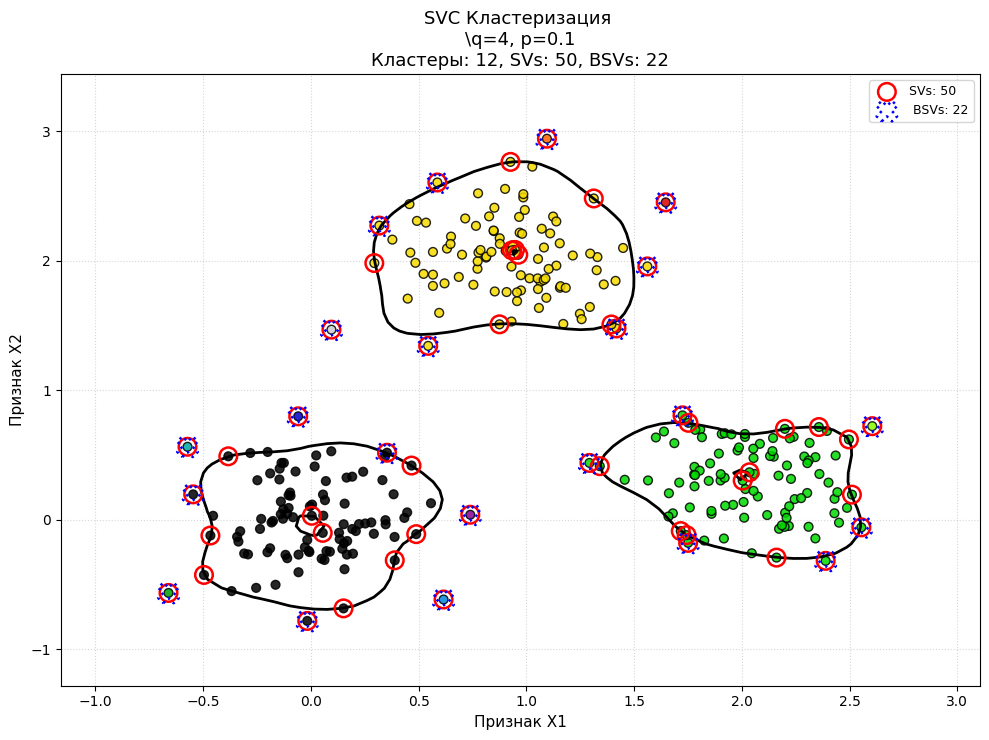

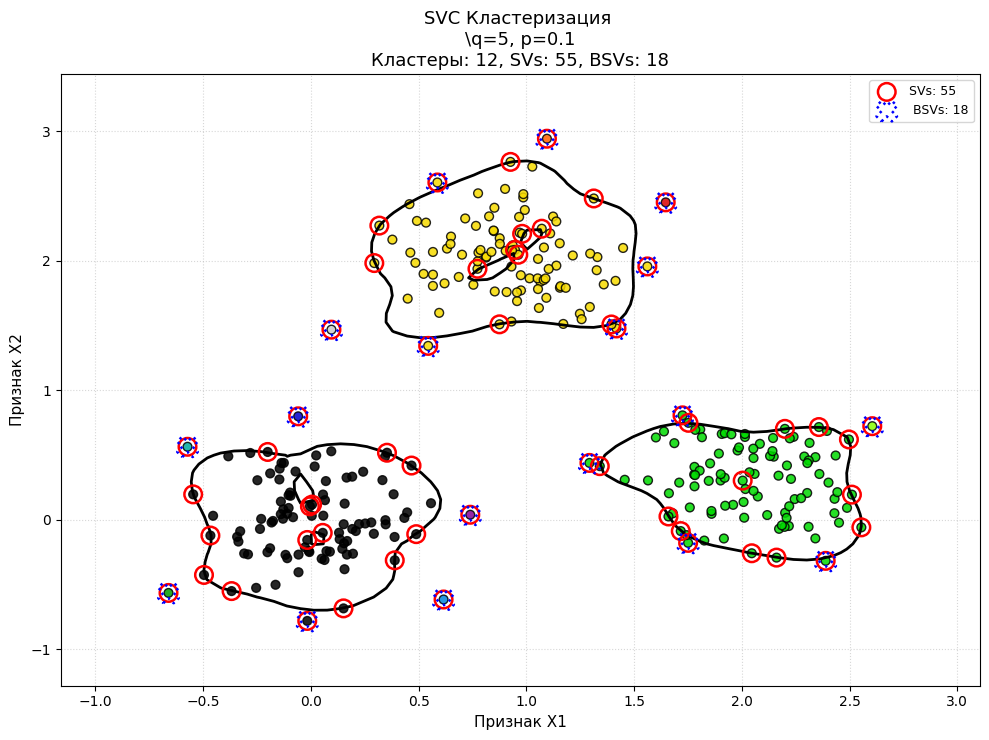

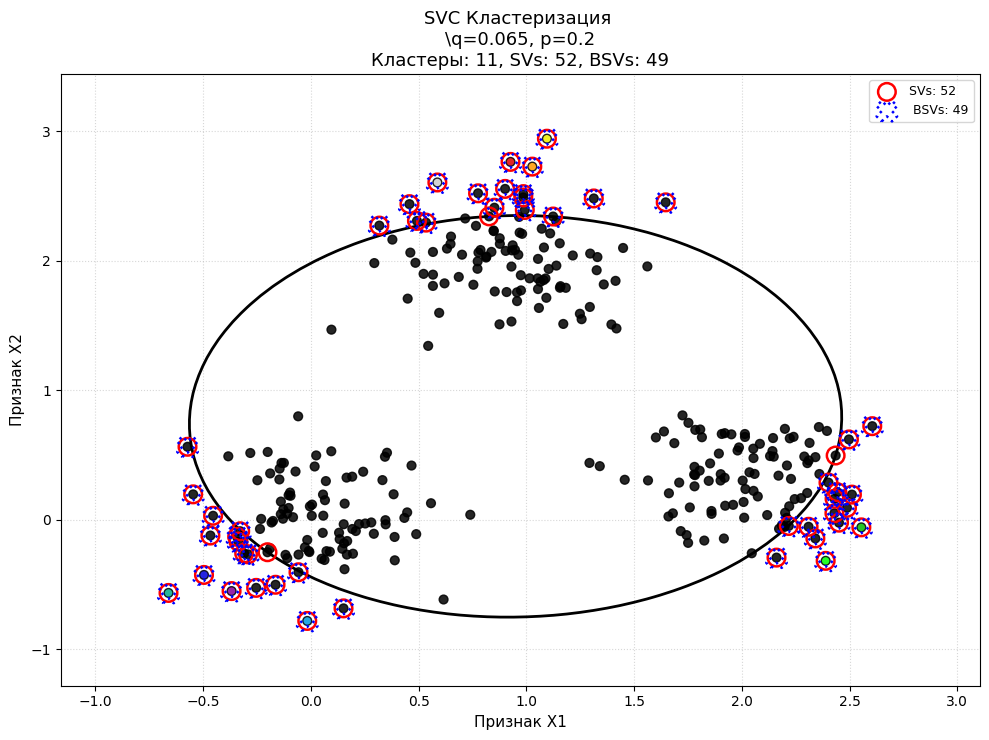

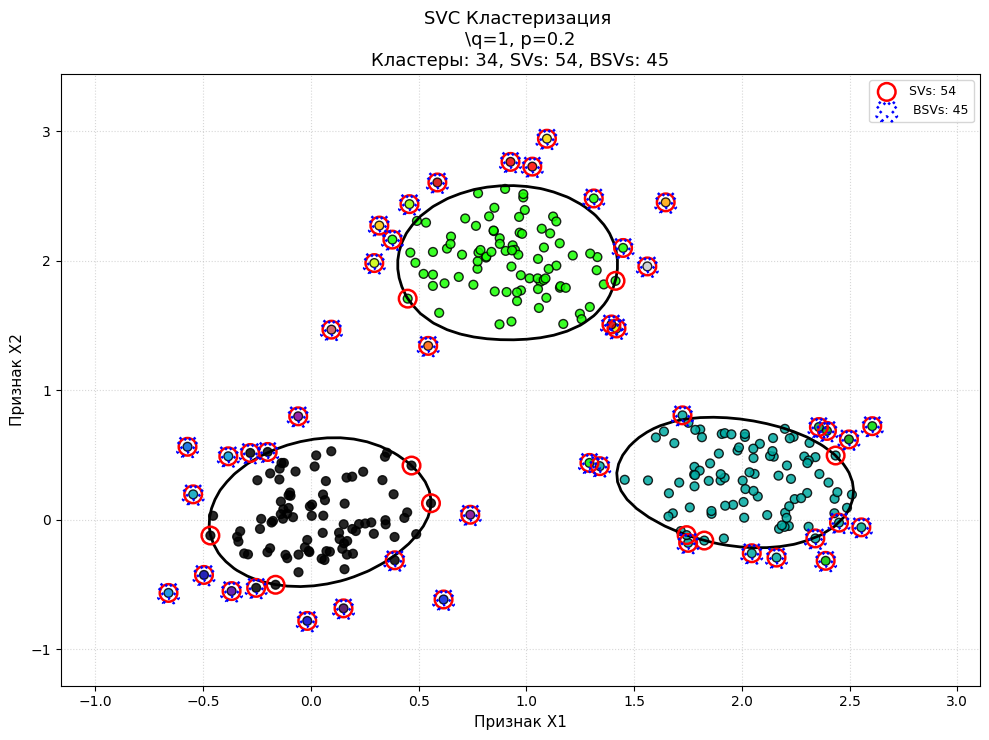

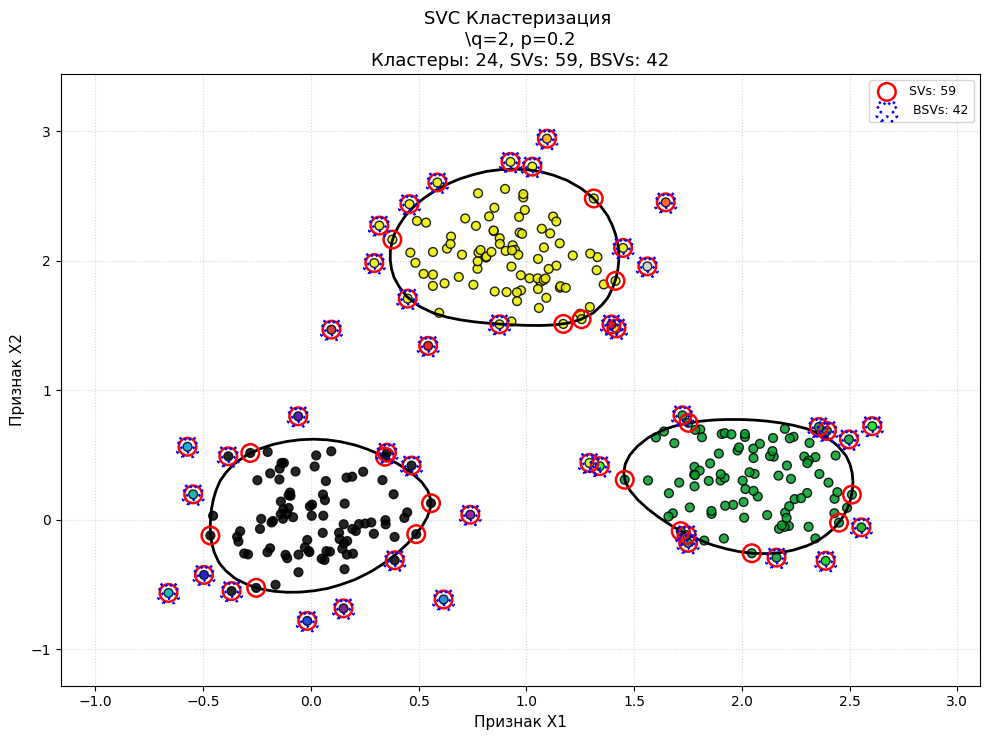

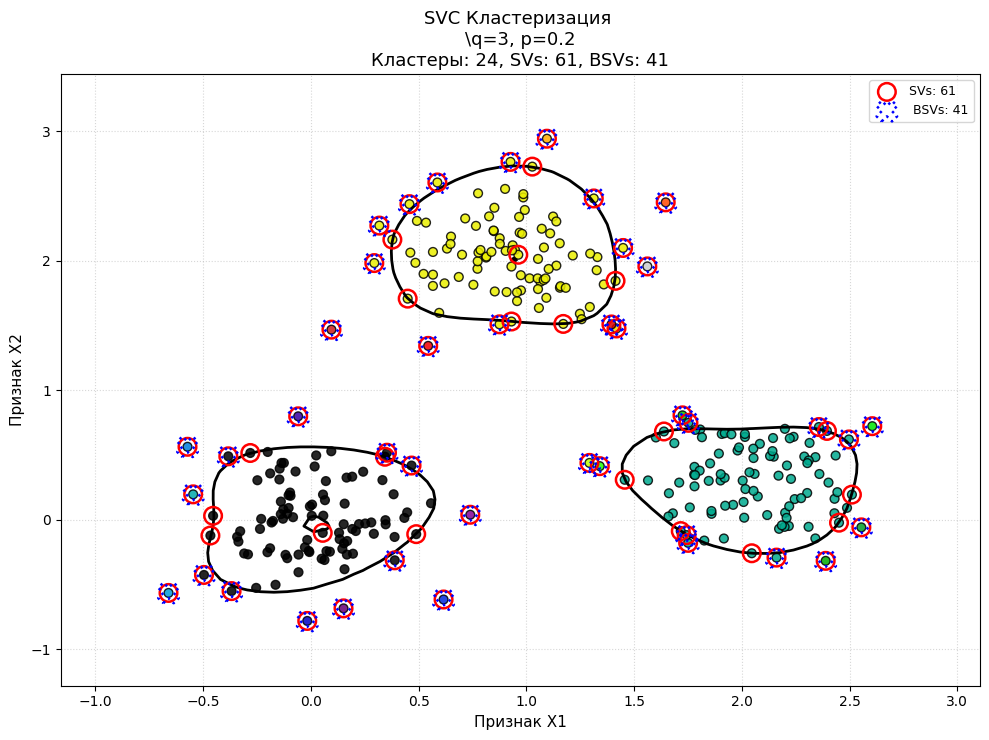

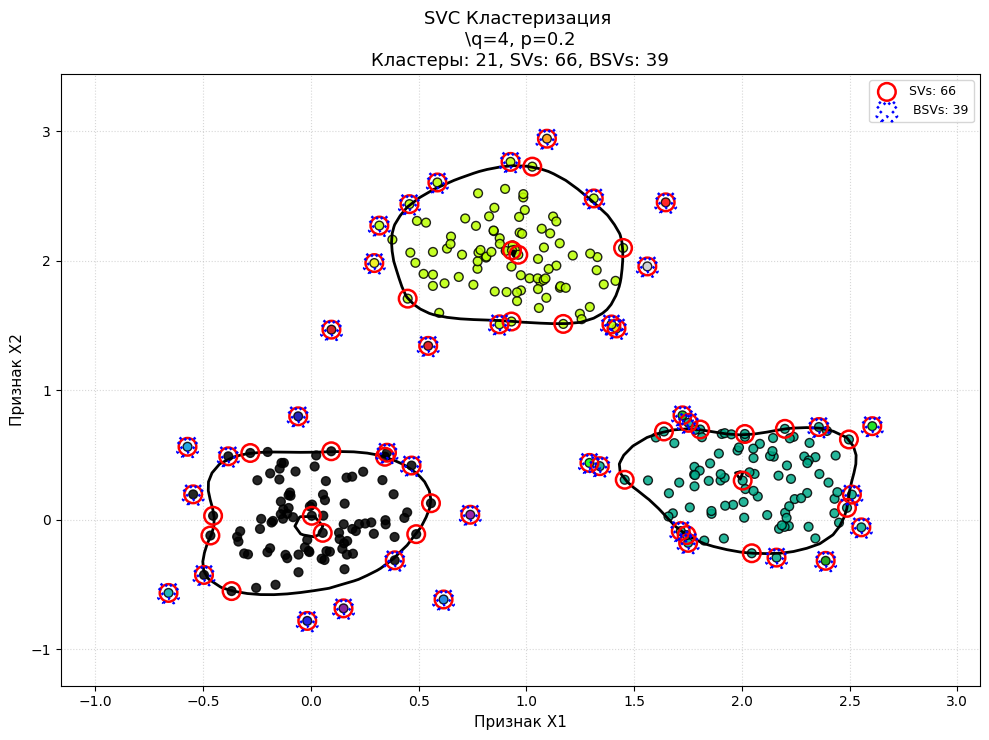

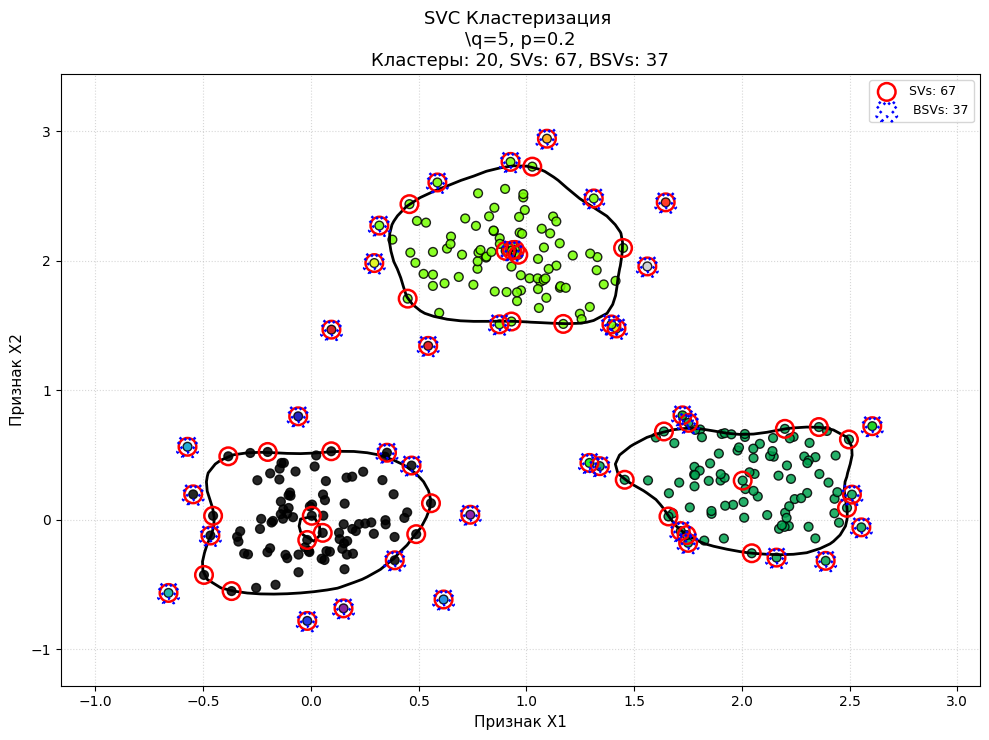

        q      p  n_clusters  n_sv  n_bsv
0   0.065  0.003           1     3      0
1   1.000  0.003           2    14      0
2   2.000  0.003           3    25      0
3   3.000  0.003           3    31      0
4   4.000  0.003           3    35      0
5   5.000  0.003           3    43      0
6   0.065  0.050           3    15     12
7   1.000  0.050           8    22      9
8   2.000  0.050           4    26      3
9   3.000  0.050           3    31      0
10  4.000  0.050           3    36      0
11  5.000  0.050           3    44      0
12  0.065  0.100           6    35     32
13  1.000  0.100          16    38     27
14  2.000  0.100          12    41     27
15  3.000  0.100          12    46     21
16  4.000  0.100          12    50     22
17  5.000  0.100          12    55     18
18  0.065  0.200          11    52     49
19  1.000  0.200          34    54     45
20  2.000  0.200          24    59     42
21  3.000  0.200          24    61     41
22  4.000  0.200          21    66

In [ ]:
table = {'q':[],
         'p':[],
         'n_clusters':[],
         'n_sv':[],
         'n_bsv':[]}

for p in [0.003, 0.05, 0.1, 0.2]:
  for q in [0.065, 1, 2, 3, 4, 5]:
    svc = SV_claster(q=q, p=p, num_segments_check=12, sv_tol=1e-4)
    try:
      svc.fit(X)
    except:
      continue
    svc.plot_clusters()

    table['q'].append(svc.q)
    table['p'].append(svc.p)
    table['n_clusters'].append(svc.n_clusters_)
    table['n_sv'].append(svc.n_sv_)
    table['n_bsv'].append(svc.n_bsv_)

table = pd.DataFrame(table)
print(table)

In [ ]:
table

q      p  n_clusters  n_sv  n_bsv
0   0.065  0.003           1     3      0
1   1.000  0.003           2    14      0
2   2.000  0.003           3    25      0
3   3.000  0.003           3    31      0
4   4.000  0.003           3    35      0
5   5.000  0.003           3    43      0
6   0.065  0.050           3    15     12
7   1.000  0.050           8    22      9
8   2.000  0.050           4    26      3
9   3.000  0.050           3    31      0
10  4.000  0.050           3    36      0
11  5.000  0.050           3    44      0
12  0.065  0.100           6    35     32
13  1.000  0.100          16    38     27
14  2.000  0.100          12    41     27
15  3.000  0.100          12    46     21
16  4.000  0.100          12    50     22
17  5.000  0.100          12    55     18
18  0.065  0.200          11    52     49
19  1.000  0.200          34    54     45
20  2.000  0.200          24    59     42
21  3.000  0.200          24    61     41
22  4.000  0.200          21    66     39
23  5.000  0.200          20    67     37

# **Работа с данными - луны**

**генерируем данные**

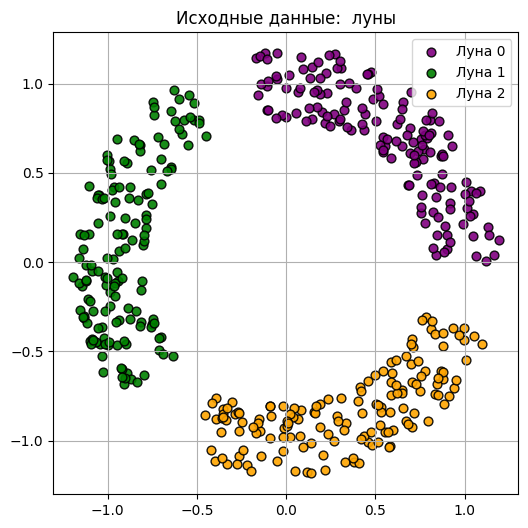

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(52)
n_per_moon = 150       # точек на каждую луну
noise_radial = 0.2     # шум
r = 1.0                # средний радиус

# Определяем три сегмента по 100 градусов с разрывом 20 градусов между
angular_spans = [
    (0, 100),      # первая луна: 0–100°
    (120, 220),    # вторая луна: 120–220°
    (240, 340),    # третья луна: 240–340°
]

def make_thick_arc(start_deg, end_deg, n_points):
    angles = np.deg2rad(rng.uniform(start_deg, end_deg, n_points))
    radii = r + rng.uniform(-noise_radial, noise_radial, size=n_points)
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return np.column_stack([x, y])

# Генерируем три луны
X_parts = []
y_parts = []
for idx, (start, end) in enumerate(angular_spans):
    X_parts.append(make_thick_arc(start, end, n_per_moon))
    y_parts.append(np.full(n_per_moon, idx, dtype=int))

X = np.vstack(X_parts)
y = np.hstack(y_parts)

# Визуализация
colors = ['purple', 'green', 'orange']
plt.figure(figsize=(6, 6))
for lab, col in zip(range(3), colors):
    plt.scatter(X[y == lab, 0], X[y == lab, 1],
                c=col, s=40, edgecolor='k', alpha=0.9, label=f'Луна {lab}')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.title("Исходные данные:  луны")
plt.show()


**подбор значений гиперпараметров**

<ipython-input-2-a454858fd87c>:162: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_map = plt.cm.get_cmap(cmap_name, max(1, num_unique_labels))


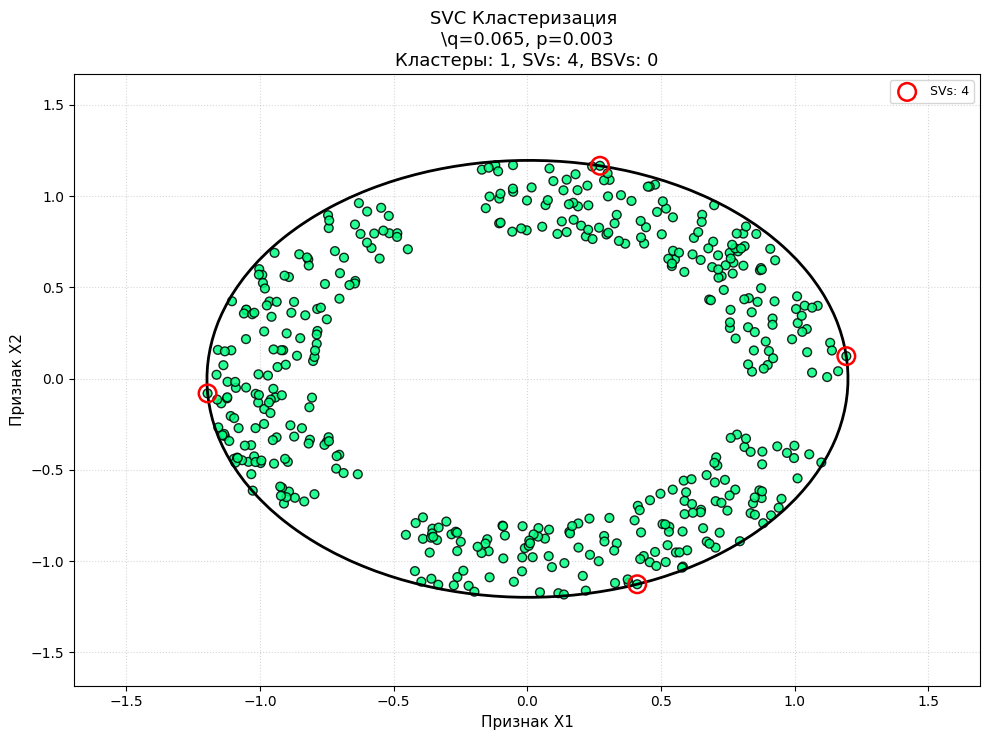

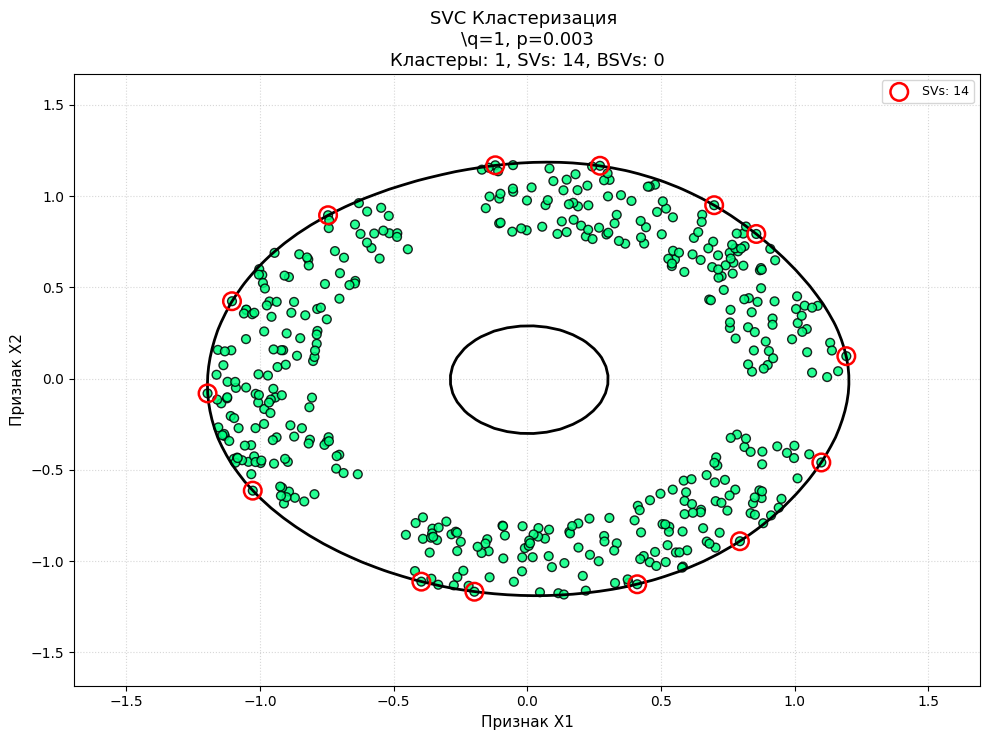

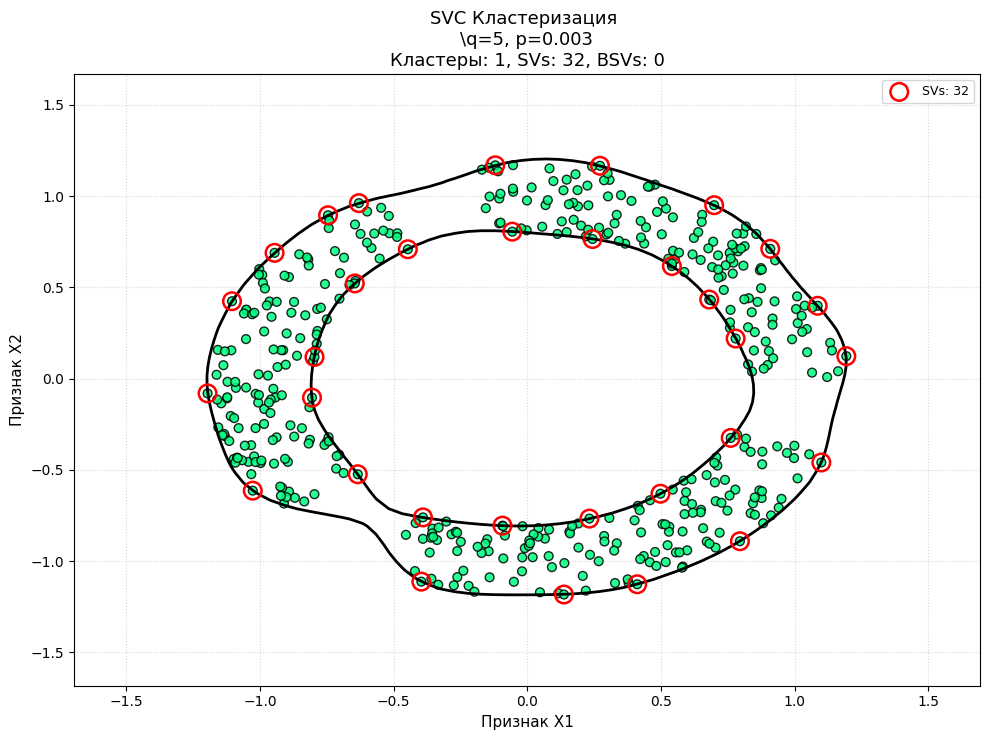

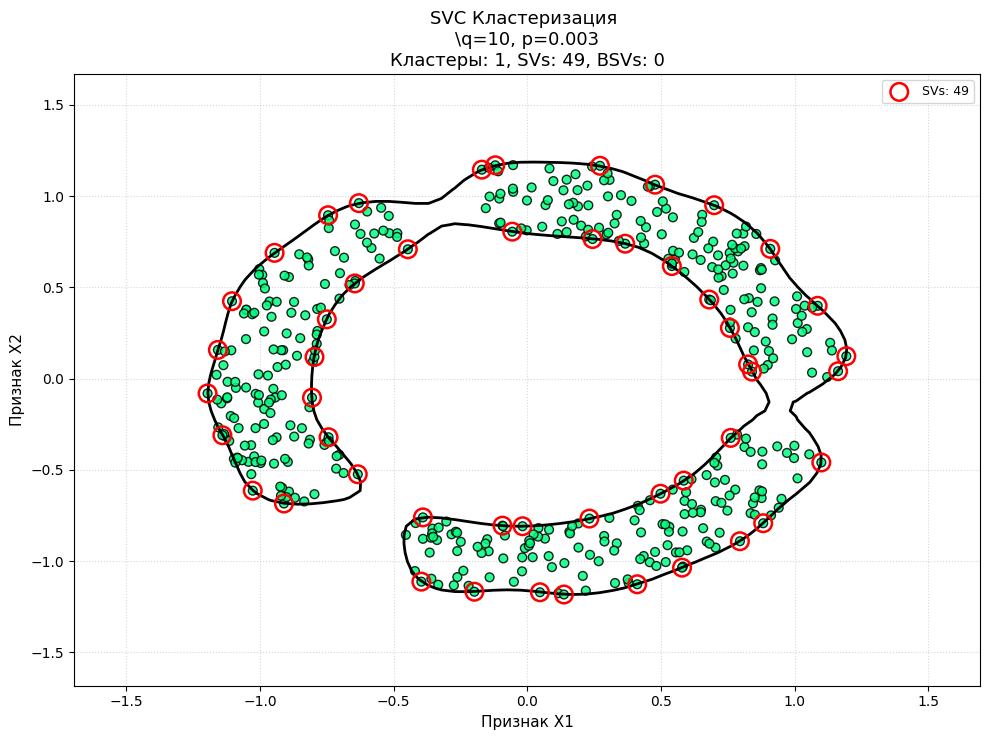

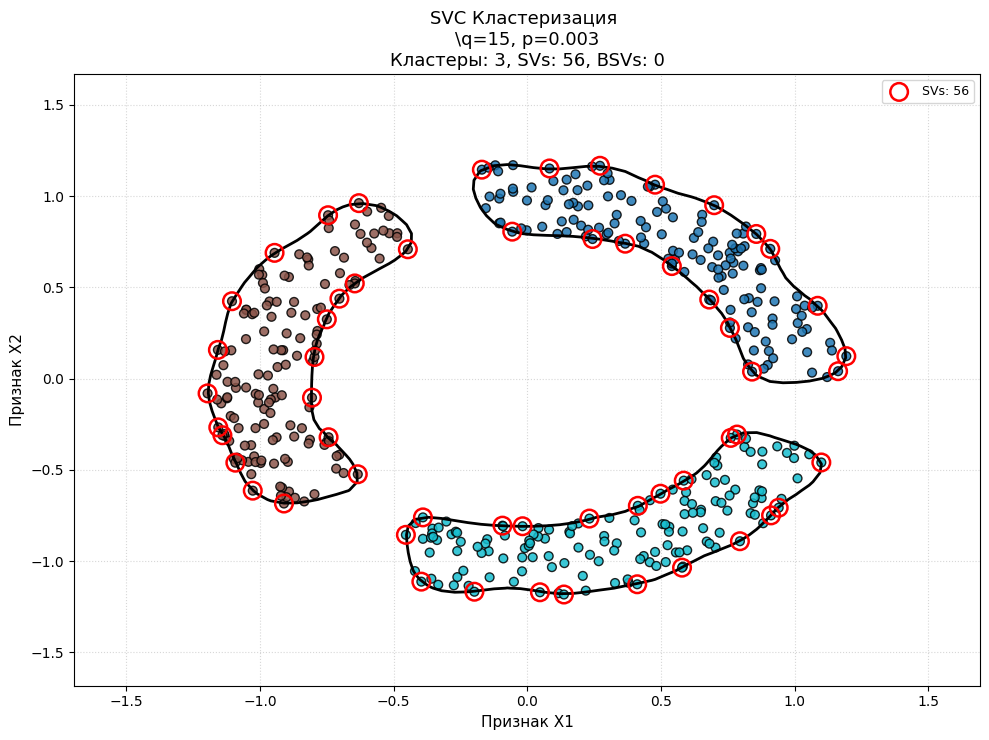

        q      p  n_clusters  n_sv  n_bsv
0   0.065  0.003           1     4      0
1   1.000  0.003           1    14      0
2   5.000  0.003           1    32      0
3  10.000  0.003           1    49      0
4  15.000  0.003           3    56      0


In [ ]:
table = {'q':[],
         'p':[],
         'n_clusters':[],
         'n_sv':[],
         'n_bsv':[]}

for p in [0.003]:
  for q in [0.065, 1, 5, 10, 15]:
    svc = SV_claster(q=q, p=p, num_segments_check=12, sv_tol=1e-4)
    try:
      svc.fit(X)
    except:
      continue
    svc.plot_clusters()

    table['q'].append(svc.q)
    table['p'].append(svc.p)
    table['n_clusters'].append(svc.n_clusters_)
    table['n_sv'].append(svc.n_sv_)
    table['n_bsv'].append(svc.n_bsv_)

table = pd.DataFrame(table)
print(table)

In [ ]:
table

q      p  n_clusters  n_sv  n_bsv
0   0.065  0.003           1     4      0
1   1.000  0.003           1    14      0
2   5.000  0.003           1    32      0
3  10.000  0.003           1    49      0
4  15.000  0.003           3    56      0